In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set(style="whitegrid")

# Problem Set 5 (covers Lab 9 and 10)

## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import models 

sns.set(style="whitegrid")

In [7]:
data= pd.read_excel('data.xlsx')

In [3]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


We know that horsepower should be a float, and we know that there are 6 null values

In [8]:
data['horsepower'] = pd.to_numeric(data['horsepower'],errors = 'coerce')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB


We see that there are exactly 392 non-null values for the numeric horsepower, which is what we expect.

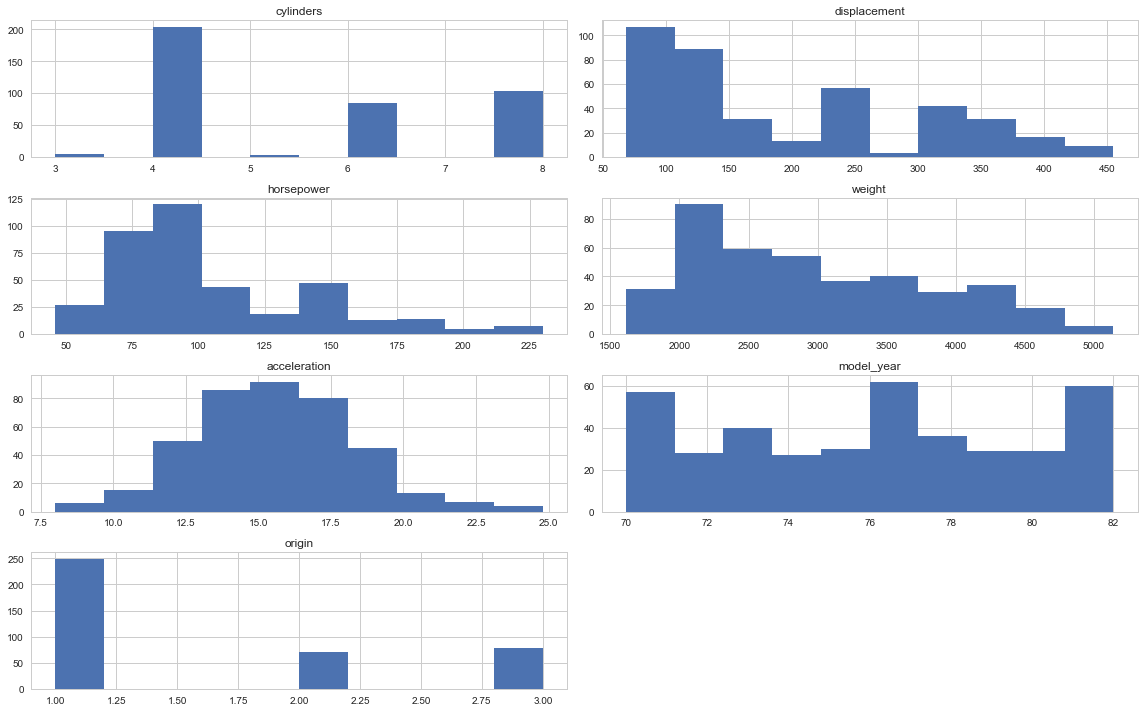

In [22]:
colnames = data.columns[1:-1]
fig = plt.figure(figsize=(16,10))
for i in range(len(colnames)):
    ax = fig.add_subplot(round(len(colnames)/2),2,i+1)
    ax.hist(data.loc[~data[colnames[i]].isnull(),colnames[i]])
    ax.set_title(colnames[i])
plt.tight_layout()
plt.show()
plt.close()

We can see that the cylinders seem to be mostly multiples of 2 (4,6,8).

Displacement seems to be right skewed, with the mode appearing between 50-100.

horsepower appears to be right skewed as well, with the mode appearing between 75-100.

Weight is also right skewed, with the mode appearing between 2000-2500 pounds.

Acceleration seems pretty normally distributed actually.

Model year appears to have a tri-modal distribution. Not sure if we actually want something like model_year in the regression. Depending on if it is a explanatory or predictive model. 

Origin seems to have a mode at 1, and 2 and 3 appear to have equal sizes.

From these observations, there could be categorical differences between origin and cylinders. This is something to keep in mind as we continue building the model. 

In [28]:
data['car_name'].ipynb_checkpoints/describe()

count            398
unique           305
top       ford pinto
freq               6
Name: car_name, dtype: object

It seems the one categorical variable is almost unique for each observation. Thus, I will discount it when creating this model. However, it might be of interest to someone who cares about what predictions are for each kind of car.

## EDA

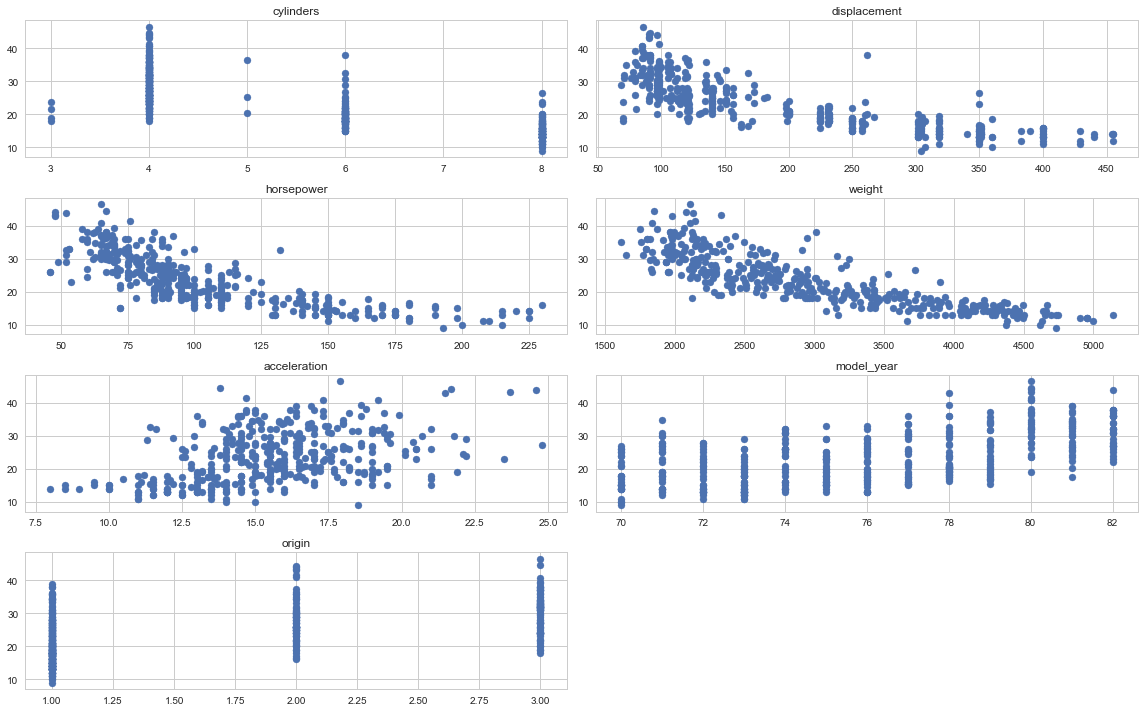

In [31]:
colnames = data.columns[1:-1]
fig = plt.figure(figsize=(16,10))
for i in range(len(colnames)):
    ax = fig.add_subplot(round(len(colnames)/2),2,i+1)
    ax.scatter(y=data.loc[~data[colnames[i]].isnull(),'mpg'],x=data.loc[~data[colnames[i]].isnull(),colnames[i]])
    ax.set_title(colnames[i])
plt.tight_layout()
plt.show()
plt.close()

It looks like there is definitely segmentation between cylinders, origin, and model year. It seems that the more cylinders there are, the less mpg on average the car gets. The more recent the car, the more mpg it gets on average. And origin of 2 and 3 get more mpg than origin of 1. 

It also appears that mpg goes down as displacement, weight, and horsepower increases. It seems that acceleration goes up, the mpg also increases, but the effect is not as strong. It could be that displacement, horsepower, and weight require variable transformation, as it does not look exactly linear in regards to their relationship.

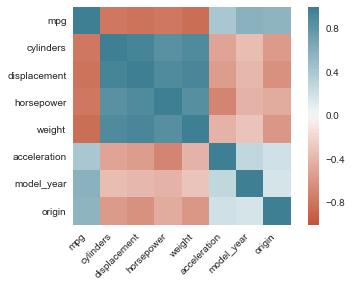

In [33]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

It looks like mpg is strongly negatively correlated with cylinders, displacement, horsepower, and weight. It looks like the positive correlation between mpg and acceleration, model_year, and origin are weaker.

it also looks like cylinders, displacement, horsepower, and weight are all strongly positively correlated with each other. This means that there's a chance that there's collinearity between these factors, and the model will not require all of these variables to be in the model. It also looks like these 4 variables have a weak negative correlation with acceleration, model_year, and origin.

It does not look like acceleration, model year, and origin are that correlated with each other. 

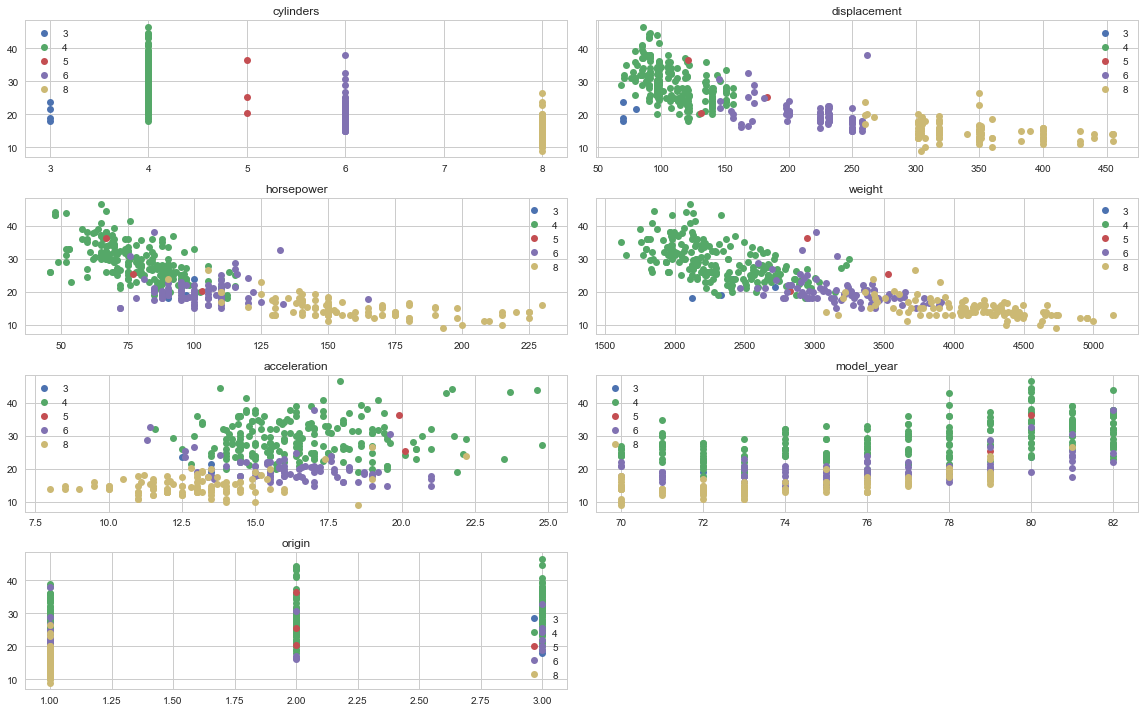

In [45]:
colnames = data.columns[1:-1]
fig = plt.figure(figsize=(16,10))

for i in range(len(colnames)):
    ax = fig.add_subplot(round(len(colnames)/2),2,i+1)
    for name,group in data.groupby('cylinders'):
        ax.plot(group.loc[~group[colnames[i]].isnull(),colnames[i]],group.loc[~group[colnames[i]].isnull(),'mpg'],label=name, marker='o', linestyle='')
        #ax.plot(group.displacement, group.mpg, marker='o', linestyle='', ms=12, label=name)
    ax.set_title(colnames[i])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

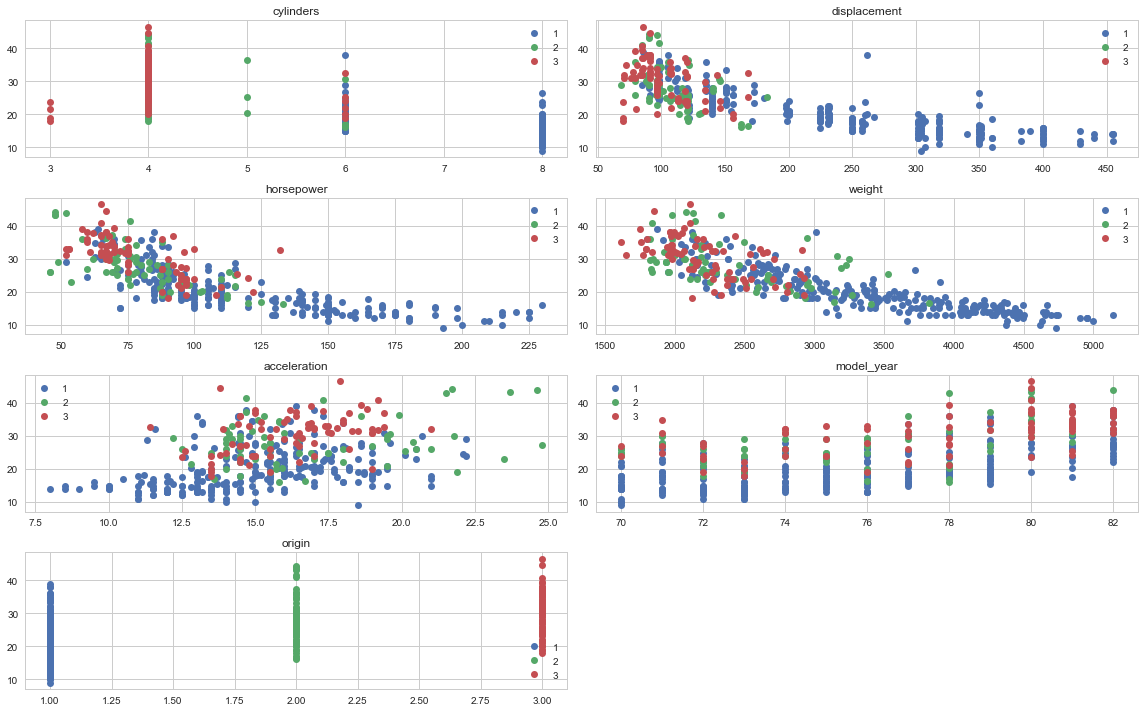

In [46]:
colnames = data.columns[1:-1]
fig = plt.figure(figsize=(16,10))

for i in range(len(colnames)):
    ax = fig.add_subplot(round(len(colnames)/2),2,i+1)
    for name,group in data.groupby('origin'):
        ax.plot(group.loc[~group[colnames[i]].isnull(),colnames[i]],group.loc[~group[colnames[i]].isnull(),'mpg'],label=name, marker='o', linestyle='')
        #ax.plot(group.displacement, group.mpg, marker='o', linestyle='', ms=12, label=name)
    ax.set_title(colnames[i])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

There does seem to be significant differences in displacement, horsepower, and weight by cylinder. The higher the cylinder, the higher the displacement, and there seems to be a significant separation. The same can be observed for weight and horespower.

There appears to be separation as well in the acceleration category. It is interesting to note the decrease of 8 cylinders over time, and how it is concentrated in just one origin. 

Origin also shows similar characterisitcs, however, we can see in the cylinders graph that origin and cylinders seem to actually be pretty correlated. 

## Data transformation

Origin seems like it should be handled as a categorical variable based on its appearance. I feel comfortable keeping cylinders as a numeric variable, because it does look like a multiplier can be applied to 6 cylinders on top of 4 cylinders and still have that make sense. 

In [47]:
data2 = pd.get_dummies(data,columns = ['origin'])

## Exploratory model building
For the first iteration of the model, I'll just throw everything in

In [49]:
results = models.bootstrap_linear_regression('mpg~cylinders + displacement+horsepower + weight + model_year+ origin_2+origin_3',data2)
models.describe_bootstrap_lr(results)

Actually, that doesn't look bad. All of our coefficients are different from 0 (except for horsepower). Our R^2 is .82, and our error is only 3.31. However, displacement looks like it actually is going the wrong direction (we expected mpg to go down as displacement went up). The other variables look like they are trending in the right direction. We'll remove that from the next build.

In [93]:
def plot_residuals(df,result, variables):
    figure = plt.figure(figsize=(20,6))

    #variables = ["age", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = len(df)
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

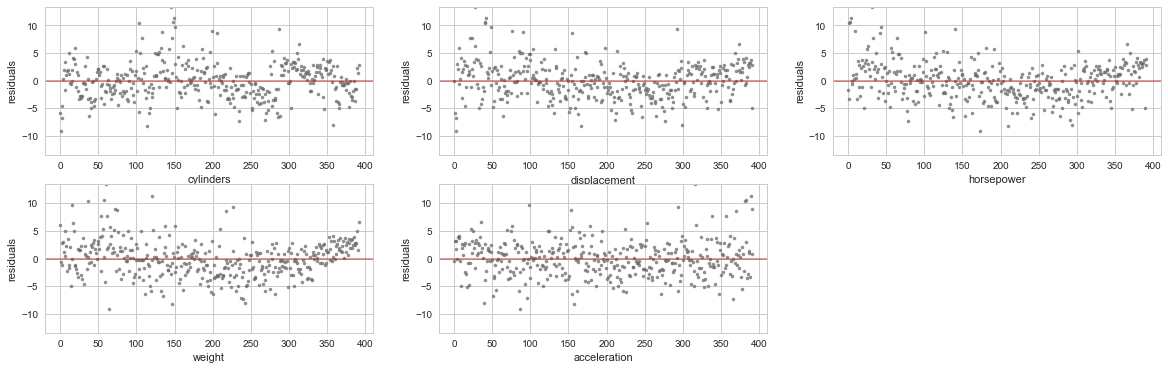

array([ 2.89293484e+00,  9.83934738e-01,  2.69662801e+00,  1.00445761e+00,
        1.90453206e+00,  4.14859059e+00,  3.19832523e+00,  3.12920858e+00,
        3.75861355e+00,  1.68830994e+00, -5.02106562e-01, -4.49982527e-01,
       -1.20441617e-01, -4.89108142e+00,  3.71086826e-01,  3.22532607e+00,
       -1.12916985e+00,  3.39440167e-01,  2.00674557e+00, -1.72617441e+00,
        3.40196522e+00,  9.83813764e-01,  1.82365344e+00,  1.96554216e+00,
        8.81874466e-01,  2.95629914e+00,  2.27608269e+00,  3.30777554e+00,
        3.47087503e+00,  1.23286223e+00,  5.00083980e+00, -3.33010164e-01,
       -2.50369801e+00, -1.49274115e-02, -4.34822545e-01,  1.09073027e+00,
        7.21022308e-01,  2.54331697e+00,  3.27199333e+00,  1.86462283e+00,
        2.18622389e+00,  4.96610215e+00,  3.96864834e+00,  6.63882963e+00,
       -1.74252521e+00, -5.18994748e-01,  1.26156606e+00, -9.62219904e-01,
        3.72944880e-02,  2.01641793e+00,  4.06460012e+00,  3.94612916e+00,
        2.95931993e+00,  

In [95]:
data3 = data.loc[~data.horsepower.isnull(),:]
plot_residuals(data3, results,data3.columns[1:6])

It does look like the residuals might be a bit shaped.

## Take 2

In [96]:
results = models.bootstrap_linear_regression('mpg~cylinders +horsepower + weight + model_year+ origin_2+origin_3',data2)
models.describe_bootstrap_lr(results)

Hmmm... for some reason cylinders is now going the opposite direction. Let's try removing that too. Our error and R^2 did not change significantly upon removing displacement.

In [97]:
results = models.bootstrap_linear_regression('mpg~ horsepower + weight + model_year+ origin_2+origin_3',data2)
models.describe_bootstrap_lr(results)

Everything seems to be trending in the right direction now. I wonder what happens if we add in interaction terms of cylinder on horesepower and weight.

In [101]:
data2['horsepower_cylinders'] = data2['horsepower']*data2['cylinders']
data2['weight_cylinders'] = data2['weight']*data2['cylinders']

In [102]:
results = models.bootstrap_linear_regression('mpg~ horsepower + weight + model_year+ origin_2+origin_3 + horsepower_cylinders +weight_cylinders',data2)
models.describe_bootstrap_lr(results)

It looks like the interaction term of weight might not add much, but horsepower seems to be much more different from 0 now. 

In [103]:
results = models.bootstrap_linear_regression('mpg~ horsepower + weight + model_year+ origin_2+origin_3 + horsepower_cylinders',data2)
models.describe_bootstrap_lr(results)

With this final model, everything is trending in the right direction, and our error seems to have decreased a bit from the initial model.

## Analysis and discussion

Our final model seems to have an intercept of -15.08. However, it is kinda meaningless in this context, since we will never have a negative mph, and we would never have 0s for all of the predictors.

It seems that with horsepower, each increase in horsepower signifies a -.07 decrease in MPH. However, the decrease is less significant for cars with higher cylinders, as evidenced by the horsepower_cylinders interaction term. 

It seems that an additional pound of weight results in approximately .01 decrease in mph.

An increase in model year increases mph by .79. However, this variable is a bit controversial to include, since we can assume that model year is not really explanatory by itself. It is rather due to the differences in model years between the cars. However, in this simplistic model, it is deserving enough to be included due to its significant explanatory power.

As noted before, origin_2 and origin_3 seem to add an additional 2.5 mph. This is probably due to some interaction with the car design, but since they are both highly explanatory, they make it into the final model.